#**FINAL PROJECT** 
### **REAL TIME FACE MASK DETECTION FOR COVID-19**


---





**Importing useful libraries**

In [ ]:
!pip install mtcnn
#Libreires

import numpy as np
import tensorflow as tf
import tensorflow.keras
import torch
import cv2
import timeit
import matplotlib.pyplot as plt
from mtcnn import MTCNN
from PIL import Image

     |████████████████████████████████| 2.3MB 23.8MB/s 


**Bounding Box**

In this section a bounding box is set to serve as a point of reference for object detection, face masks in this case, and creates a collision box for that object. As it can be seen, data annotators are drawn with well defined rectangles to cover on images for detecting a face mask. This outlining is referenced within each image by defining its X and Y coordinates and its width and height parameters. 

In [ ]:
def resizeBoundingBox(image_dimens, bbox, percentage = 0.05):
  if percentage < .01 or percentage > 1. : raise Exception("Percentage not allowed. Range [0.01 - 1]")
  x, y, w, h = bbox
  image_width, image_height = image_dimens
  total_width,total_height = (x+w, y+h)
  
  paddingWidth = int(total_width * percentage)
  paddingHeight = int(total_height * percentage)
  
  new_x = 0 if(x-paddingWidth < 0) else x - paddingWidth
  new_y = 0 if(y-paddingHeight < 0) else y - paddingHeight
  
  new_w = new_x + w + (paddingWidth * 2)
  new_h = new_y + h + (paddingHeight * 2)

  new_w = image_width if(new_w > image_width) else w + (paddingWidth * 2)
  new_h = image_height if(new_h > image_height) else h + (paddingHeight * 2)

  return new_x, new_y, new_w, new_h

**Detected Face**

In this section it is uploaded the MTCNN model detection for detecting faces with and without a feature. This correlation is depicted as to the definition of two functions for these two references. 

In [ ]:
import numpy as np
import cv2

def detect_faces(img, face_model, confidence=0.5, target_size=(160, 160), enable_generator=False):
    faces = face_model.detect_faces(img)
    img_color = img.copy()
    index = 1
    for face in faces:
        bbox = face['box']
        cnf = face['confidence']
        if cnf >= confidence:
            x,y,w,h = bbox
            img_face_slice = img[y:(y + h),x:(x + w), :]
            img_resize = cv2.resize(img_face_slice, target_size, cv2.INTER_AREA)      
            cv2.rectangle(img_color, (x, y), (x + w, y + h), (0,255,0), 3)
            if (enable_generator):
                cv2.imwrite(f'face_{str(index)}.jpg', img_resize[:,:,::-1])
                index = index + 1
    return img_color


def detect_faces_with_mask(img, face_model, mask_model, classes=["No Barbijo", 'mask'], confidence=0.5, bbox_percentage=0.1, predictor='keras', target_size=(160,160)):
    if predictor != 'keras' and predictor != 'torch': raise Exception('Predictor must be keras or torch')
    
    faces = face_model.detect_faces(img)
    img_color = img.copy()
    for face in faces:
        bbox = face['box']
        cnf = face['confidence']
        if cnf >= confidence:
            x, y, w, h = resizeBoundingBox((img.shape[1], img.shape[0]), bbox, bbox_percentage)
            img_face_slice = img[y:(y + h),x:(x + w), :]
            img_resize = cv2.resize(img_face_slice, target_size, cv2.INTER_AREA)
            pred,_ = predict(mask_model, classes, np.expand_dims(img_resize[:,:,::-1], axis = 0)) if predictor == 'keras' else model_predict(mask_model, img_resize, classes)
            color = (0,255, 0) if pred == 'Si Barbijo' else (255,0,0)
            cv2.rectangle(img_color, (x, y), (x + w, y + h), color, 3)
            cv2.putText(img_color, pred.replace("_", " ").capitalize(), (x-2, y-7), cv2.FONT_HERSHEY_SIMPLEX, .9, color, 2)
    return img_color

**Keras predictor**

In this block the prediction gets ready, to perform predictive analytics in order to seeks future events or outcomes, in what concerns to image feature analysis, using the keras library.

In [ ]:
def predict(model, classes, image):
    prob = model.predict(image)
    pred = 0 if prob[0] < 0.5 else 1
    return (classes[pred], prob)

**PyTorch predictor**

In this block the prediction gets ready, to perform predictive analytics in order to seeks future events or outcomes, in what concerns to image feature analysis, using the PyTorch library.

In [ ]:
import torch
import numpy as np
from torch.autograd import Variable
from torchvision import transforms
from PIL import Image

def model_predict(model, image, classes = None):

    image = Image.fromarray(image) # eliminar en caso el input sea del tipo PIL.Image
    
    data_transforms = transforms.Compose([
    transforms.Resize(160),
    transforms.CenterCrop(160), 
    transforms.ToTensor(),
    transforms.Normalize([0.5737, 0.4802, 0.4410],[0.2369, 0.2243, 0.2235])])

    use_gpu = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_gpu else "cpu")   

    model.eval() 

    imgblob = data_transforms(image)
    imgblob.unsqueeze_(dim=0)
    imgblob = Variable(imgblob)
    torch.no_grad()

    imgblob = imgblob.to(device)

    output = model(imgblob)
    prob, pred = torch.max(output, 1)

    if classes is None:
        return(int(pred),float(prob))
    else:
        return(classes[int(pred)],float(prob))

**Unziping dataset information**

In [ ]:
!unzip Cont.zip

Archive:  Cont.zip
  inflating: image1.jpg              
  inflating: mask_net.hdf5           
  inflating: Model001.model          


**Referencial definition of parameters**

With this referencial parameters, it is provided, a general referencial format to process image information. 

In [ ]:
#Variable configuration
#Width
Width = 160 
#Height
Height = 160 
#Bounding Box
BoundingBox = 0.05 
#Percentage
Percentage = 0.80 
#Class
Class = ['No Barbijo', 'Si Barbijo'] 

**Showing a referencial format test with an image**

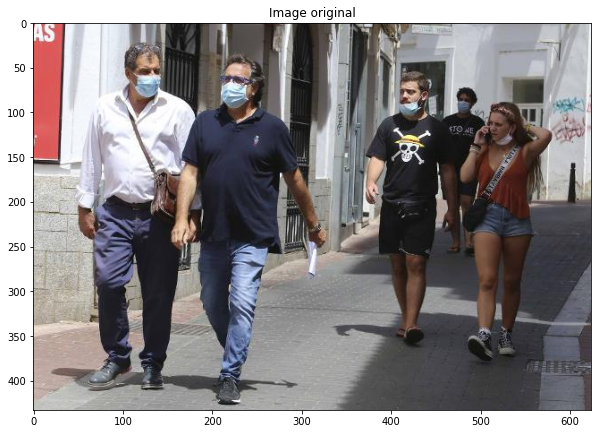

In [ ]:
# Load the image
img = cv2.imread('image1.jpg')
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#Show image
plt.figure(figsize=(10, 10))
plt.title("Image original")
plt.imshow(imgRGB)
plt.show()

**Load Model (Multi-Task Cascaded Convolutional Neural Network)**

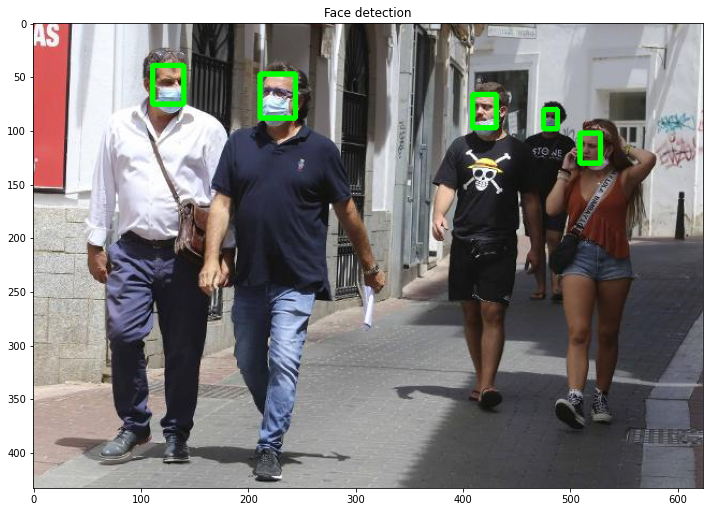

In [ ]:
# Load Model(Multi-Task Cascaded Convolutional Neural Network)
Detector = MTCNN()
#Face detection
imageFace = detect_faces(imgRGB, Detector, confidence=Percentage, target_size=(Width, Height))
#Show image
plt.figure(figsize=(12, 12))
plt.title('Face detection')
plt.imshow(imageFace)
plt.show()

**Model mask Keras (MaskNet)**

In [ ]:
# MaskNet
model_keras = tf.keras.models.load_model('mas.hdf5')

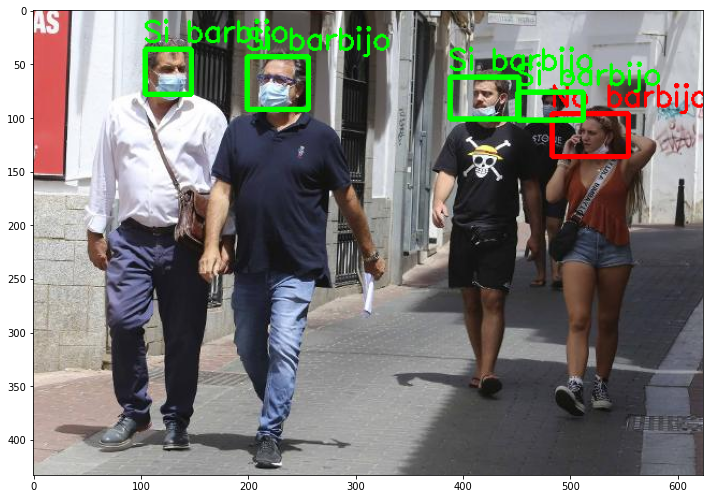

In [ ]:
#Application of Keras
imagedetection = detect_faces_with_mask(imgRGB, Detector, model_keras, Class, 
                                   Percentage, bbox_percentage=BoundingBox, predictor='keras', 
                                   target_size=(Width, Height))
#Show image
plt.figure(figsize=(12, 12))
plt.imshow(imagedetection)
plt.show()

**Using Pytorch Transfer Learning (ResNet18)**

In [ ]:
model_torch = torch.load('Model001.model')

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torchvision.models.resnet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set

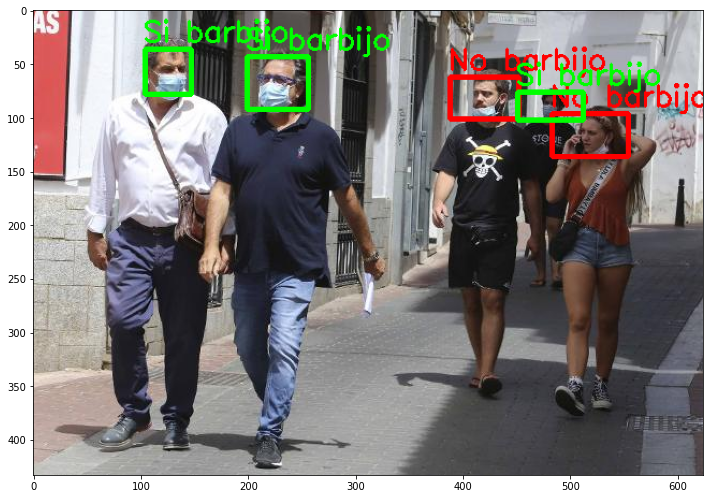

In [ ]:
#Application of Pythorch
imagedetection2 = detect_faces_with_mask(imgRGB, face_detector, model_torch, ["Si Barbijo", "No Barbijo"], 
                                              Percentage, bbox_percentage=BoundingBox, predictor='torch', 
                                              target_size=(Width, Height))
#Show image
plt.figure(figsize=(12, 12))
plt.imshow(imagedetection2)
plt.show()

**Mask Video Model Keras**

In [ ]:
#Load Video
%%time
video = cv2.VideoCapture('video.mp4')
W = None
H = None
writer = None
#Read video
while True:
  _, frame = video.read()

  if frame is None:
    break

  if W is None or H is None:
    (H, W) = frame.shape[:2]

# Inicializar el writer
  
  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
#Saved Video output
    writer = cv2.VideoWriter('VideoF.avi', fourcc, 30, (W, H), True)

  img_color = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#Application of Keras
  img_color_temp = detect_faces_with_mask(img_color, face_detector, model_keras, classes, 
                                          CONFIDENCE, bbox_percentage=BBOX_PERCENTAGE, predictor='keras',
                                          target_size=(IMG_WIDTH, IMG_HEIGHT))
  if writer is not None:
    writer.write(img_color_temp[:,:,::-1])      

if writer is not None:
  writer.release()

video.release()

CPU times: user 7min, sys: 11.2 s, total: 7min 11s
Wall time: 7min 1s


**Model Video Pytorch**

In [ ]:
%%time
#Load Video
video = cv2.VideoCapture('video.mp4')
W = None
H = None
writer = None
#Read video
while True:
    _, frame = video.read()

    if frame is None:
        break

    if W is None or H is None:
        (H, W) = frame.shape[:2]

# Inicializar el writer
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
#Saved Video output
        writer = cv2.VideoWriter('VideoF2.avi', fourcc, 30, (W, H), True)

    img_color = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#Application of Pytorch
    img_color_temp = detect_faces_with_mask(img_color, face_detector, model_torch, ["Si Barbijo", "No Barbijo"], 
                                          CONFIDENCE, bbox_percentage=BBOX_PERCENTAGE, predictor='torch',
                                          target_size=(IMG_WIDTH, IMG_HEIGHT))
    if writer is not None:
        writer.write(img_color_temp[:,:,::-1])      

if writer is not None:
    writer.release()

video.release()

CPU times: user 6min 33s, sys: 9.96 s, total: 6min 43s
Wall time: 6min 32s


**For testing Keras**

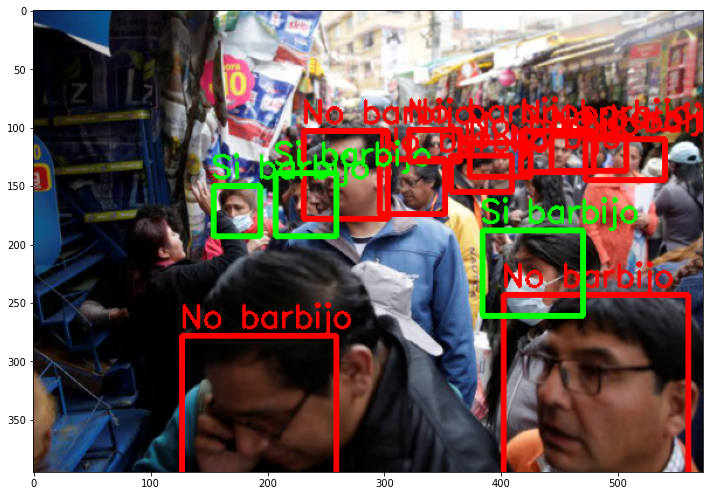

In [ ]:
#Load Image
imgtest = cv2.imread('image2.jpg')
imgRGBtest = cv2.cvtColor(imgtest, cv2.COLOR_BGR2RGB)
#Application of Keras
imagetestF = detect_faces_with_mask(imgRGBtest, Detector, model_keras, classes, 
                                    Percentage, bbox_percentage=BoundingBox, predictor='keras', 
                                    target_size=(Width, Height))
#Show image
plt.figure(figsize=(12, 12))
plt.imshow(imagetestF)
plt.show()

**For testing Pytorch**

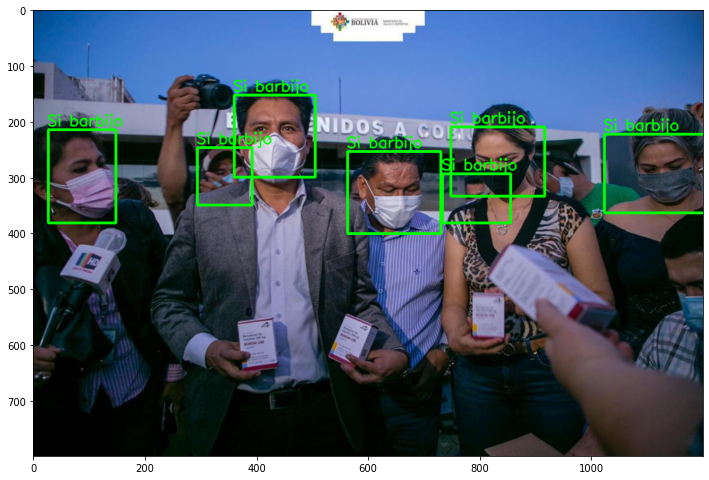

In [ ]:
#Load Image
imgtest2 = cv2.imread("image3.jpg")
imgRGBtest2 = cv2.cvtColor(imgtest2, cv2.COLOR_BGR2RGB)
#Application of Pythorch
imagetestF2 = detect_faces_with_mask(imgRGBtest2, Detector, model_torch, ["Si Barbijo", "No Barbijo"], 
                                            Percentage, bbox_percentage=BoundingBox, predictor='torch', 
                                              target_size=(Width, Height))
#Show image
plt.figure(figsize=(12, 12))
plt.imshow(imagetestF2)
plt.show()